<a href="https://colab.research.google.com/github/bella-xia/Medical_Image/blob/main/medical_image_week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from pickle import dump, load

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

In [ ]:
import collections
import hashlib
import inspect
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import requests
from IPython import display

In [ ]:
from IPython.terminal.pt_inputhooks import get_inputhook_name_and_func
from IPython.utils.process import getoutput

In [ ]:
import skimage
from skimage.color import gray2rgb

# Self-Defined Classes and Functions for DL

In [ ]:
def use_svg_display():
  backend_inline.set_matplotlib_formats('svg')

In [ ]:
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
  use_svg_display()
  plt.rcParams['figure.figsize'] = figsize


In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
  axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
  axes.set_xscale(xscale), axes.set_yscale(yscale)
  axes.set_xlim(xlim), axes.set_ylim(ylim)
  if legend:
    axes.legend(legend)
  axes.grid()

In [ ]:
def gpu(i=0):
    """Get a GPU device.

    Defined in :numref:`sec_use_gpu`"""
    return torch.device(f'cuda:{i}')

def num_gpus():
    """Get the number of available GPUs.

    Defined in :numref:`sec_use_gpu`"""
    return torch.cuda.device_count()

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.

    Defined in :numref:`sec_use_gpu`"""
    return [gpu(i) for i in range(num_gpus())]

In [ ]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
  def has_one_axis(X):
    return (hasattr(X, 'ndim') and X.ndim == 1 or isinstance(X, list) and
            not hasattr(X[0], '__len__'))
  if has_one_axis(X): X = [X]
  if Y is None:
    X, Y = [[]] * len(X), X
  elif has_one_axis(Y):
    Y = [Y]
  if len(X) != len(Y):
    X = X * len(Y)

  set_figsize(figsize)
  if axes is None:
    axes = plt.gca()
  axes.cla()
  for x, y, fmt in zip(X, Y, fmts):
    axes.plot(x, y, fmt) if len(x) else axes.plot(y, fmt)
  set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [ ]:
class Animator:

  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear', yscale='linear',
               fmts = ('-', 'm--', 'g-.', 'r:'),
               nrows=1, ncols=1, figsize=(3.5, 2.5)):
               if legend is None:
                legend = []
               use_svg_display()
               self.fig, self.axes = plt.subplots(nrows,
                                                 ncols, figsize=figsize)
               if nrows * ncols == 1:
                self.axes = [self.axes, ]
               self.config_axes = lambda: set_axes(self.axes[0], xlabel,
                                                  ylabel, xlim, ylim,
                                                  yscale, legend)
               self.X, self.Y, self.fmts = None, None, fmts
  def add(self, x, y):
    if not hasattr(y, '__len__'):
      y = [y]
    n = len(y)
    if not hasattr(x, '__len__'):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)



In [ ]:
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

In [ ]:
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)

In [ ]:
def cpu():
    """Get the CPU device.

    Defined in :numref:`sec_use_gpu`"""
    return torch.device('cpu')

In [ ]:
class HyperParameters:
  def save_hyperparameters(self, ignore=[]):
    frame = inspect.currentframe().f_back
    _, _, _, local_vars = inspect.getargvalues(frame)
    self.hparams = {k:v for k, v in local_vars.items() if k not in set(ignore+['self']) and not k.startswith('_')}
    for k, v in self.hparams.items():
      setattr(self, k, v)

In [ ]:
class ProgressBoard(HyperParameters):
  def __init__(self, xlabel=None, ylabel=None, xlim=None,
               ylim=None, xscale='linear', yscale='linear',
               ls=['-', '--', '-.', ':'],
               colors=['C0', 'C1', 'C2', 'C3'],
               fig=None, axes=None, figsize=(3.5, 2.5), display=True):
    self.save_hyperparameters()

  def draw(self, x, y, label, every_n=1):
    Point = collections.namedtuple('Point', ['x', 'y'])
    if not hasattr(self, 'raw_points'):
      self.raw_points = collections.OrderedDict()
      self.data = collections.OrderedDict()
    if label not in self.raw_points:
      self.raw_points[label] = []
      self.data[label] = []
    points = self.raw_points[label]
    line = self.data[label]
    points.append(Point(x, y))
    if len(points) != every_n:
      return
    mean = lambda x : sum(x) / len(x)
    line.append(Point(mean([p.x for p in points]),
                      mean([p.y for p in points])))
    points.clear()
    if not self.display:
      return
    use_svg_display()
    if self.fig is None:
      self.fig = plt.figure(figsize=self.figsize)
    plt_lines, labels = [], []
    for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
      plt_lines.append(plt.plot([p.x for p in v],
                                [p.y for p in v],
                                linestyle=ls, color=color)[0])
      labels.append(k)
    axes = self.axes if self.axes else plt.gca()
    if self.xlim: axes.set_xlim(self.xlim)
    if self.ylim: axes.set_ylim(self.ylim)
    if not self.xlabel: self.xlabel = self.x
    axes.set_xlabel(self.xlabel)
    axes.set_ylabel(self.ylabel)
    axes.set_xscale(self.xscale)
    axes.set_yscale(self.yscale)
    axes.legend(plt_lines, labels)
    display.display(self.fig)
    display.clear_output(wait=True)

In [ ]:
class Module(nn.Module, HyperParameters):
  def __init__(self, plot_train_per_epoch = 2, plot_valid_per_epoch=1):
    super().__init__()
    self.save_hyperparameters()
    self.board = ProgressBoard()

  def loss(self, y_hat, y):
    raise NotImplementedError

  def forward(self, X):
    assert hasattr(self, 'net'), 'Neural network is defined'
    return self.net(X)

  def plot(self, key, value, train):
     """Plot a point in animation."""
     assert hasattr(self, 'trainer'), 'Trainer is not inited'
     self.board.xlabel = 'epoch'
     if train:
      x = self.trainer.train_batch_idx / \
          self.trainer.num_train_batches
      n = self.trainer.num_train_batches / \
          self.plot_train_per_epoch
     else:
      x = self.trainer.epoch + 1
      n = self.trainer.num_val_batches / \
          self.plot_valid_per_epoch
      self.board.draw(x, numpy(to(value, cpu())),
       ('train_' if train else 'val_') + key,
                      every_n=int(n))

  def training_step(self, batch):
    Y_hat = self(*batch[:-1])
    l = self.loss(Y_hat, batch[-1])
    self.plot('loss', l, train=True)
    return l

  def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=False)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)


In [ ]:
class DataModule(HyperParameters):

    def __init__(self):
      super().__init__()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

In [ ]:
class Timer:

  def __init__(self):
    self.times = []
    self.start()

  def start(self):
    self.tik = time.time()

  def stop(self):
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    return sum(self.times) / len(self.times)

  def sum(self):
    return sum(self.times)

  def cumsum(self):
    return np.array(self.times).cumsum().tolist()

In [ ]:
class Accumulator:

  def __init__(self, n):
    self.data = [0.0] * n

  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
class Trainer(HyperParameters):

    def __init__(self, max_epochs, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpu = try_gpu()

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_batch(self, batch):
        batch = [to(a, self.gpu) for a in batch]
        return batch

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        model.to(self.gpu)
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def clip_gradients(self, grad_clip_val, model):
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm

In [ ]:
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

In [ ]:
def accuracy(self, Y_hat, Y, averaged=True):
  Y_hat = reshape(Y_hat, (-1, Y_hat.shape[-1]))
  preds = astype(argmax(Y_hat, axis=1), Y.dtype)
  compare = astype(preds == reshape(Y, -1), torch.float32)
  return reduce_mean(compare) if averaged else compare

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):

  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device

  metric = Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(accuracy(net(X), y), size(y))
  return metric[0] / metric[1]

In [ ]:
class Classifier(Module):
  def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
    self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

  def accuracy(self, Y_hat, Y, averaged=True):
    Y_hat = reshape(Y_hat, -1)
    preds = astype(torch.round(torch.sigmoid(Y_hat)), Y.dtype)
    compare = astype(preds == reshape(Y, -1), torch.float32)
    return reduce_mean(compare) if averaged else compare

  def loss(self, Y_hat, Y, averaged=True):
    Y_hat = reshape(Y_hat, (-1, Y_hat.shape[-1]))
    print(Y_hat)
    print(Y)
    return F.binary_cross_entropy_with_logits(Y_hat, Y)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
      X = layer(X)
      print(layer.__class__.__name__, 'output shape:\t', X.shape)

# Create Data Module

In [ ]:
device = try_gpu()

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Medical Image/data/df_20.h5', 'rb') as f:
  df = load(f)

In [ ]:
df.head()

,extent_right_numerical,density_right_numerical,extent_left_numerical,density_left_numerical,mRALE Score,img
0,4,3,4,2,20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,3,3,3,2,15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,1,1,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
def encode_ordinal(num_levels, curr_level):
  arr = torch.zeros(num_levels)
  for i in range(curr_level):
    arr[i] = 1
  return arr

In [ ]:
def encode_arr(arr):
  num_levels = arr.max()
  length = arr.shape[0]
  tensor = encode_ordinal(num_levels, arr[0]).unsqueeze(dim=0)
  for i in range(1, length):
    tensor = torch.cat((tensor, encode_ordinal(num_levels, arr[i]).unsqueeze(dim=0)), 0)
  return tensor

In [ ]:
def prepare_data(df):
  img = torch.tensor(np.asarray(df['img'].tolist()), dtype=torch.float32)
  img = img.unsqueeze(dim=1)
  extent_right = encode_arr(np.asarray(df['extent_right_numerical'].tolist()))
  density_right = encode_arr(np.asarray(df['density_right_numerical'].tolist()))
  extent_left = encode_arr(np.asarray(df['extent_left_numerical'].tolist()))
  density_left = encode_arr(np.asarray(df['density_left_numerical'].tolist()))
  return img, extent_right, density_right, extent_left, density_left

In [ ]:
img, extent_right, density_right, extent_left, density_left = prepare_data(df)

In [ ]:
img

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.6952, 0.6919, 0.6931,  ..., 0.8220, 0.7709, 0.1727],
          [0.6955, 0.6977, 0.6937,  ..., 0.8255, 0.7735, 0.1742],
          [0.6204, 0.6198, 0.6227,  ..., 0.7348, 0.6995, 0.2174]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4016, 0.7693, 0.7804,  ..., 0.7333, 0.7304, 0.7232],
          [0.4219, 0.7231, 0.7474,  ..., 0.7308, 0.7155, 0.7104],
          [0.5713, 0.4116, 0.4075,  ..., 0.7202, 0.7175, 0.7141]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [ ]:
class MedicalImage(DataModule):
  def __init__(self, index, X, y, batch_size=32):
    super().__init__()
    self.save_hyperparameters()
    self.num_train =int(len(self.X) / 10 * 9)
    self.num_val = len(self.X) - self.num_train
    print(self.num_train)
    print(self.num_val)

  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

# self-constructed resnet

In [ ]:
class Residual(nn.Module):
  def __init__(self, num_channels, use1x1conv=False, stride=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels,kernel_size=3,
                               padding=1, stride=stride)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3,
                               padding=1)
    if use1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                 stride=stride)
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [ ]:
class ResNet(Classifier):

  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
    nn.LazyLinear(num_classes)))
    self.net.apply(init_cnn)

  def b1(self):
    return nn.Sequential(nn.LazyConv2d(64, kernel_size=7,
                                       stride=2, padding=3),
                         nn.LazyBatchNorm2d(), nn.ReLU(),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

  def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(num_channels, use1x1conv=True, stride=2))
      else:
        blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
class ResNet18(ResNet):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                     lr, num_classes)

In [ ]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
model = ResNet18(lr=0.01, num_classes=4)
trainer = Trainer(max_epochs=10)
data = MedicalImage(0, img, extent_right, batch_size=64)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

18
2


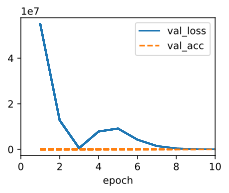

In [ ]:
trainer.fit(model, data);

In [ ]:
df.iloc[10]

extent_right_numerical                                                     2
density_right_numerical                                                    1
extent_left_numerical                                                      0
density_left_numerical                                                     0
mRALE Score                                                                2
img                        [[0.4941856543015837, 0.4988491042550892, 0.44...
Name: 10, dtype: object

In [ ]:
img = df.iloc[10]['img']

In [ ]:
img_tensor = torch.tensor(img, dtype=torch.float32)

In [ ]:
img_tensor

tensor([[0.4942, 0.4988, 0.4459,  ..., 0.5172, 0.5252, 0.5323],
        [0.4957, 0.4923, 0.4361,  ..., 0.5155, 0.5192, 0.5356],
        [0.4954, 0.4984, 0.4264,  ..., 0.5137, 0.5196, 0.5327],
        ...,
        [0.4387, 0.7928, 0.7673,  ..., 0.4748, 0.4666, 0.4558],
        [0.4277, 0.7391, 0.6183,  ..., 0.4791, 0.4654, 0.4601],
        [0.4745, 0.3682, 0.4153,  ..., 0.4948, 0.4814, 0.4717]])

In [ ]:
img

array([[0.49418565, 0.4988491 , 0.44592702, ..., 0.51715647, 0.52520242,
        0.53227894],
       [0.49574549, 0.49230382, 0.43613582, ..., 0.51554217, 0.51921185,
        0.53557421],
       [0.49543338, 0.49842225, 0.42637829, ..., 0.5137332 , 0.5195728 ,
        0.532651  ],
       ...,
       [0.43865947, 0.79280945, 0.76729071, ..., 0.47480674, 0.466615  ,
        0.45575062],
       [0.42766412, 0.73911772, 0.61834116, ..., 0.47913996, 0.46544894,
        0.46008258],
       [0.47447381, 0.36824368, 0.41533994, ..., 0.49484183, 0.48138751,
        0.47165903]])

In [ ]:
img_tensor.unsqueeze(dim=0).unsqueeze(dim=0).shape

torch.Size([1, 1, 512, 512])

In [ ]:
torch.round(torch.sigmoid(model(img_tensor.unsqueeze(dim=0).unsqueeze(dim=0).to(try_gpu()))))

tensor([[0., 0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
df['mRALE Score'].max()

20